In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop import LpLoss, H1Loss

In [2]:
# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
from torch.utils.data import DataLoader
from neuralop.utils import get_project_root
from neuralop.data.datasets import DarcyDataset

example_data_root = get_project_root() / "neuralop/data/datasets/data"

def fake_load_darcy_flow_small(n_train,
                               n_tests,
                               batch_size,
                               test_batch_sizes,
                               data_root=example_data_root,
                               test_resolutions=[16, 32],
                               encode_input=False,
                               encode_output=True,
                               encoding="channel-wise",
                               channel_dim=1, ):
    dataset = DarcyDataset(root_dir=data_root,
                           n_train=n_train,
                           n_tests=n_tests,
                           batch_size=batch_size,
                           test_batch_sizes=test_batch_sizes,
                           train_resolution=16,
                           test_resolutions=test_resolutions,
                           encode_input=encode_input,
                           encode_output=encode_output,
                           channel_dim=channel_dim,
                           encoding=encoding,
                           download=True)

    # return dataloaders for backwards compat
    train_loader = DataLoader(dataset.train_db,
                              batch_size=batch_size,
                              num_workers=0,
                              pin_memory=True,
                              persistent_workers=False, )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(dataset.test_dbs[res],
                                       batch_size=test_bsize,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True,
                                       persistent_workers=False, )

    return train_loader, test_loaders, dataset.data_processor

In [4]:
train_loader, test_loaders, output_encoder = fake_load_darcy_flow_small(
    n_train=100,
    batch_size=16,
    test_resolutions=[16, 32],
    n_tests=[100, 50],
    test_batch_sizes=[32, 32],
)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [5]:
model = FNO(
    max_n_modes=(16, 16),
    n_modes=(2, 2),
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
)
model = model.to(device)
n_params = count_model_params(model)

In [6]:
optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# If one wants to use Incremental Resolution, one should use the IncrementalDataProcessor - When passed to the trainer, the trainer will automatically update the resolution
# Incremental_resolution : bool, default is False
#    if True, increase the resolution of the input incrementally
#    uses the incremental_res_gap parameter
#    uses the subsampling_rates parameter - a list of resolutions to use
#    uses the dataset_indices parameter - a list of indices of the dataset to slice to regularize the input resolution
#    uses the dataset_resolution parameter - the resolution of the input
#    uses the epoch_gap parameter - the number of epochs to wait before increasing the resolution
#    uses the verbose parameter - if True, print the resolution and the number of modes
data_transform = IncrementalDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    device=device,
    subsampling_rates=[2, 1],
    dataset_resolution=16,
    dataset_indices=[2, 3],
    epoch_gap=10,
    verbose=True,
)

data_transform = data_transform.to(device)

Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8


In [7]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {"h1": h1loss, "l2": l2loss}
print("\n### N PARAMS ###\n", n_params)
print("\n### OPTIMIZER ###\n", optimizer)
print("\n### SCHEDULER ###\n", scheduler)
print("\n### LOSSES ###")
print("\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###")
print(f"\n * Train: {train_loss}")
print(f"\n * Test: {eval_losses}")
sys.stdout.flush()


### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x13e657230>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x13e657230>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x13d68da30>}


In [8]:
# Finally pass all of these to the Trainer
trainer = IncrementalFNOTrainer(
    model=model,
    n_epochs=20,
    data_processor=data_transform,
    device=device,
    verbose=True,
    incremental_loss_gap=False,
    incremental_grad=True,
    incremental_grad_eps=0.9999,
    incremental_loss_eps = 0.001,
    incremental_buffer=5,
    incremental_max_iter=1,
    incremental_grad_max_iter=2,
)

trainer.train(
    train_loader,
    test_loaders,
    optimizer,
    scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
)

Training on 100 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([16, 1, 8, 8])
[0] time=0.22, avg_loss=0.9309, train_err=13.2987


/Users/fangjun/Documents/stanford/acoustic-no/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Eval: 16_h1=0.8880, 16_l2=0.6512, 32_h1=0.9212, 32_l2=0.6529
[1] time=0.20, avg_loss=0.7841, train_err=11.2012
Eval: 16_h1=0.8061, 16_l2=0.5755, 32_h1=0.9186, 32_l2=0.5769
[2] time=0.19, avg_loss=0.6862, train_err=9.8025
Eval: 16_h1=0.7630, 16_l2=0.4417, 32_h1=0.8810, 32_l2=0.4611
[3] time=0.18, avg_loss=0.6085, train_err=8.6924
Eval: 16_h1=0.7075, 16_l2=0.3756, 32_h1=0.9002, 32_l2=0.3984
[4] time=0.18, avg_loss=0.5492, train_err=7.8459
Eval: 16_h1=0.7810, 16_l2=0.4181, 32_h1=1.1075, 32_l2=0.4603
[5] time=0.19, avg_loss=0.5102, train_err=7.2881
Eval: 16_h1=0.7520, 16_l2=0.4026, 32_h1=1.0766, 32_l2=0.4511
[6] time=0.19, avg_loss=0.4573, train_err=6.5322
Eval: 16_h1=0.6242, 16_l2=0.3374, 32_h1=0.8883, 32_l2=0.3803
[7] time=0.19, avg_loss=0.4168, train_err=5.9538
Eval: 16_h1=0.5825, 16_l2=0.3224, 32_h1=0.8010, 32_l2=0.3501
[8] time=0.21, avg_loss=0.3825, train_err=5.4645
Eval: 16_h1=0.6723, 16_l2=0.3926, 32_h1=0.9990, 32_l2=0.4398
[9] time=0.19, avg_loss=0.3764, train_err=5.3765
Eval: 16_

{'train_err': 3.8936821052006314,
 'avg_loss': 0.2725577473640442,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.43501337501220405,
 '16_h1': tensor(0.3136),
 '16_l2': tensor(0.1977),
 '32_h1': tensor(0.4510),
 '32_l2': tensor(0.2131)}

/var/folders/qh/c7l883gn5s548l5w18l25cwc0000gn/T/nix-shell.BE06J9/ipykernel_40504/2098455258.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


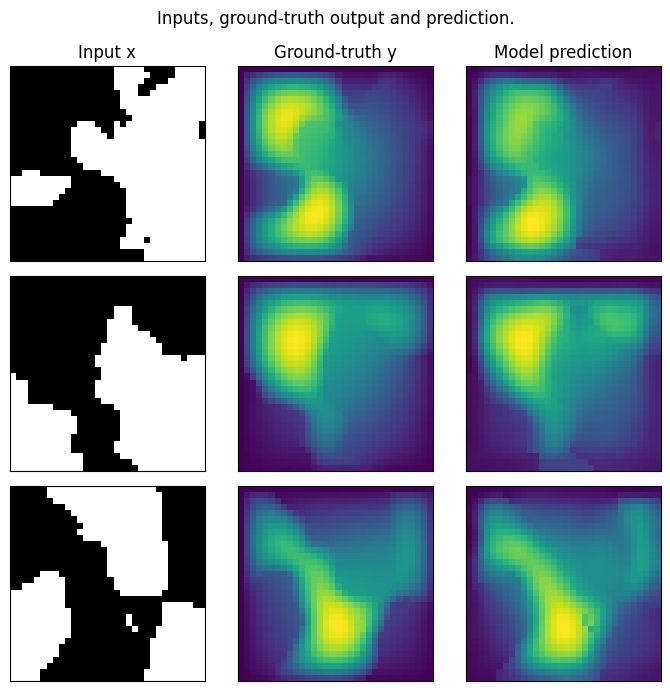

In [9]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data["x"].to(device)
    # Ground-truth
    y = data["y"].to(device)
    # Model prediction
    out = model(x.unsqueeze(0))
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    x = x.cpu().squeeze().detach().numpy()
    y = y.cpu().squeeze().detach().numpy()
    ax.imshow(x, cmap="gray")
    if index == 0:
        ax.set_title("Input x")
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title("Ground-truth y")
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title("Model prediction")
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle("Inputs, ground-truth output and prediction.", y=0.98)
plt.tight_layout()
fig.show()